# Example STIX flare: 22 Apr 2022, M1 GOES class
### Data available here: [link](https://drive.google.com/file/d/1DeIlEu3S8OgkCxWcA6iOkwKPD3xb3qIz)

This example is a bit more "manual" for data processing than the RHESSI example.
For instance, we need to manually slice out the counts and effective exposure.
This is very verbose but at least the intent is clear.

As the STIX Python interface becomes more developed,
a lot of the steps done by hand here will be obviated,
and code in the `extern` module can get dropped or replaced.

In [1]:
import os
# Set this to speed up parallelized MCMC
os.environ["OMP_NUM_THREADS"] = "4"

import astropy.time as atime
import astropy.units as u
import numpy as np

from typing import Callable

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('nice.mplstyle')

from yaff.extern import stix
from yaff import fitting, plotting

from example_support import thermal_and_thick

## Load in all of the data and do some massaging to make it good to use

In [2]:
data_fn = 'stix data/m1-stix-pixel.fits'
srm_fn = 'stix data/m1-stix-srm.fits'

srm = stix.load_srm(srm_fn, att_state='unattenuated')
spectrogram = stix.load_pixel_data_to_spectrogram(data_fn)

# The response matrix energy bins and data energy bins don't match:
# clip the (150, nan) keV bin from the data
for k in ('counts', 'counts_error'):
    spectrogram[k] = spectrogram[k][:, :-1]

spectrogram['energy_bin_edges'] = spectrogram['energy_bin_edges'][:-1]

# Not only that, but the livetime includes the (0, 4) keV bin, so we also
# need to clip that (restrict the indices from 1:-1 aka cut bins 0 and 31)
spectrogram['livetime'] = spectrogram['livetime'][:, 1:-1]

## Now, pick some times that we want to fit by looking at the light curves

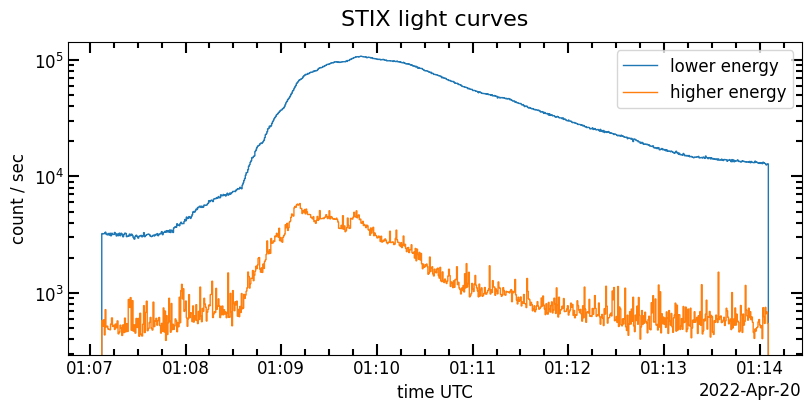

In [3]:
# Pick a nice background time before the flare and get the counts out
fig, ax = plt.subplots()

time_bins = spectrogram['time_bin_edges']

cts = spectrogram['counts']
low_energy_cts = cts[:, :cts.shape[1]//3].sum(axis=1)
high_energy_cts = cts[:, cts.shape[1]//3:].sum(axis=1)
dt = (time_bins[1:] - time_bins[:-1]).to(u.s)

ax.stairs(low_energy_cts / dt, spectrogram['time_bin_edges'].to_datetime(), label='lower energy')
ax.stairs(high_energy_cts / dt, spectrogram['time_bin_edges'].to_datetime(), label='higher energy')
ax.set(xlabel='time UTC', ylabel='count / sec', yscale='log', title='STIX light curves')
ax.legend()
plt.show()

## Pick a pre-flare background and a few seconds in the impulsive phase to fit

In [4]:
# Pick some times before the flare onset for background subtraction
bkg_start, bkg_end = atime.Time(('2022-04-20T01:07:10', '2022-04-20T01:07:30'))

# For event analysis, let's look at the impulsive phase
evt_start, evt_end = atime.Time(('2022-04-20T01:08:50', '2022-04-20T01:09:00'))

# Use the time bin midpoints to restrict count ranges
# This has a couple of advantages over using the edges:
# 1. the midpoint array is the same shape as the counts array
# 2. the midpoints are less ambiguous in terms of "time ranges"
#    because you don't need to pick "left of" or "right of" an edge
dt = (time_bins[1:] - time_bins[:-1]).to(u.s)
time_mids = time_bins[:-1] + dt/2

# Find indices for start and end of bkg and event
nearest = lambda a, v: np.argmin(np.abs(a - v))
bkg_start_idx, bkg_end_idx = nearest(time_mids, bkg_start), nearest(time_mids, bkg_end)
evt_start_idx, evt_end_idx = nearest(time_mids, evt_start), nearest(time_mids, evt_end)

# Slice out the counts, errors, and effective exposure that we want
effective_exposure = (dt * spectrogram['livetime'].T).T

# Shorthand variables for slicing
cts = spectrogram['counts']
err = spectrogram['counts_error']

event_slice = slice(evt_start_idx, evt_end_idx)

sliced_counts = cts[event_slice].sum(axis=0)
sliced_errors = np.sqrt(np.sum(err[event_slice]**2, axis=0))

# Add on a 10% systematic error to all energy bins
systematic = 0.1
sliced_errors = np.sqrt(sliced_errors**2 + (systematic * sliced_counts)**2)

# Sum up the effective exposure across the event interval
sliced_effective_exposure = effective_exposure[event_slice].sum(axis=0)

# Scale the background counts by the effective exposure
bkg_slice = slice(bkg_start_idx, bkg_end_idx)
scaled_bkg_counts = (cts[bkg_slice].sum(axis=0) / dt[bkg_slice].sum()) * sliced_effective_exposure
scaled_bkg_errors = (np.sqrt(np.sum(err[bkg_slice]**2, axis=0)) / dt[bkg_slice].sum()) * sliced_effective_exposure

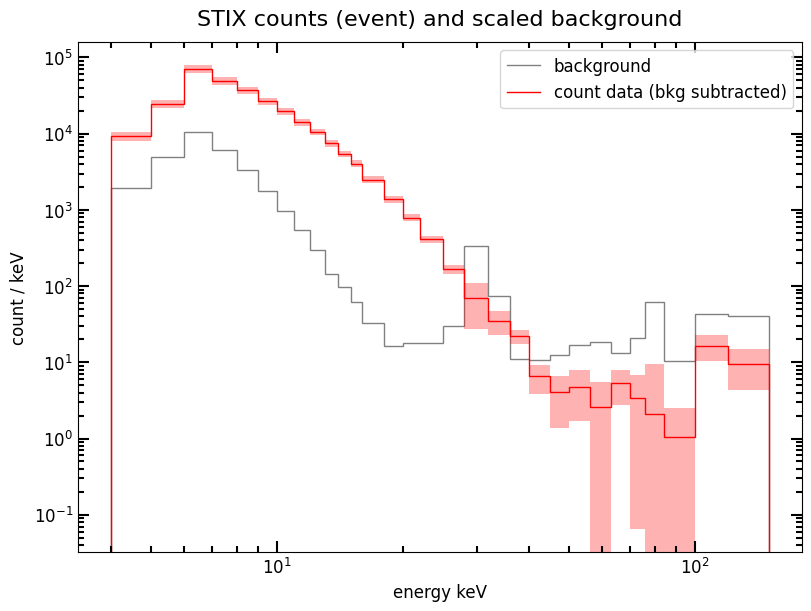

In [5]:
# Plot the spectrum to see if it worked out
fig, ax = plt.subplots(figsize=(8, 6))

de = u.Quantity(np.diff(spectrogram['energy_bin_edges'])) << u.keV

ax.stairs(scaled_bkg_counts.value / de.value, spectrogram['energy_bin_edges'].value, label='background', color='gray')

plotting.stairs_with_error(
    bins=spectrogram['energy_bin_edges'],
    quant=(sliced_counts - scaled_bkg_counts) / de,
    error=np.sqrt(sliced_errors**2 + scaled_bkg_errors**2) / de,
    ax=ax,
    label='count data (bkg subtracted)',
    line_kw={'color': 'red'}
)

ax.set(
    xlabel='energy keV',
    ylabel='count / keV',
    xscale='log',
    yscale='log',
    title='STIX counts (event) and scaled background'
)
ax.legend()

plt.show()

## Data looks good; let's set up the fitter, parameters, and likelihood.

In [6]:
# Let's steal the parameters from the RHESSI flare--single nonthermal
# electron population with a single thermal component.

# Define the parameters with their initial guesses (all frozen to start)
starting_parameters = {
    'temperature': fitting.Parameter(10 << u.MK, frozen=True),
    'emission_measure': fitting.Parameter(1 << (1e49 * u.cm**-3), frozen=True),
    'electron_flux': fitting.Parameter(20 << (1e35 * u.electron / u.s), frozen=True),
    'spectral_index': fitting.Parameter(5 << u.one, frozen=True),
    'cutoff_energy': fitting.Parameter(5 << u.keV, frozen=True)
}

# The priors we give are just "bounds" on
# the physical values. They could be something
# more interesting like a truncated normal,
# or some other probability distribution.
log_priors = {
    'temperature': fitting.simple_bounds(0, 100),
    'emission_measure': fitting.simple_bounds(0, 10000),
    'electron_flux': fitting.simple_bounds(0, 10000),
    'spectral_index': fitting.simple_bounds(2, 20),
    'cutoff_energy': fitting.simple_bounds(1, 90)
}

# Name the parameter groups so we can loop
# over them later
thermal_names = ['temperature', 'emission_measure']
nonthermal_names = ['electron_flux', 'spectral_index', 'cutoff_energy']

In [7]:
# This time around, let's be clever when defining the likelihood function
# so that an energy range can be dynamically swapped for fitting
def chi_squared_factory(energy_bounds: np.ndarray) -> Callable[[fitting.DataPacket, np.ndarray], float]:
    e_start, e_end = energy_bounds
    def log_likelihood(data: fitting.DataPacket, model: np.ndarray) -> float:
        '''Basic chi2 log likelihood, which subtracts the
        background from the data'''
        restrict = (e_start <= data.count_energy_mids) & (data.count_energy_mids <= e_end)
        # Some count bins might be negative, so use nan_to_num
        return -np.nan_to_num(
            ((data.counts - data.background_counts - model)**2 / (data.counts_error**2 + data.background_counts_error**2))[restrict]
        ).sum()

    return log_likelihood

In [8]:
data_packet = fitting.DataPacket(
    counts=sliced_counts,
    counts_error=sliced_errors,
    background_counts=scaled_bkg_counts,
    background_counts_error=scaled_bkg_errors,
    effective_exposure=sliced_effective_exposure,
    count_energy_edges=spectrogram['energy_bin_edges'],
    photon_energy_edges=srm['photon_energy_edges'],
    # We need to take the transpose here again
    # so that we can do (SRM) @ (photons),
    # rather than (photons) @ (srm)
    response_matrix=(srm['area'] * srm['srm']).T
)

log_likelihood = chi_squared_factory([5, 40])
fitter = fitting.BayesFitter(
    data=data_packet,
    model_function=thermal_and_thick,
    parameters=starting_parameters,
    log_priors=log_priors,
    log_likelihood=log_likelihood
)

## First use Levenberg-Marquadt to minimize the parameters via least-squares

In [9]:
# Fit the nonthermal parameters using chi2 minimization
for k in thermal_names:
    fitter.parameters[k].frozen = False

print('Fit thermal params')
fitter = fitting.levenberg_minimize(fitter)

# Now fit the nonthermal stuff, changing the fit range
for k in thermal_names:
    fitter.parameters[k].frozen = True
for k in nonthermal_names:
    fitter.parameters[k].frozen = False

print('Fit nonthermal params')
log_likelihood = chi_squared_factory([20, 70])
fitter.log_likelihood = log_likelihood
fitter = fitting.levenberg_minimize(fitter)

# Finally, fit all the parameters
for k in fitter.parameters.keys():
    fitter.parameters[k].frozen = False

print('Fit all params')
log_likelihood = chi_squared_factory([5, 70])
fitter.log_likelihood = log_likelihood
fitter = fitting.levenberg_minimize(fitter)

fitter.parameters

Fit thermal params
Fit nonthermal params
Fit all params


/home/william/dev/yaff/yaff/fitting.py:561: UserWarning: minimization failed; whatever
  warnings.warn("minimization failed; whatever")


OrderedDict([('temperature', Parameter(1.45e+01, MK, frozen=False)),
             ('emission_measure',
              Parameter(5.67e-02, 1e+49 / cm3, frozen=False)),
             ('electron_flux',
              Parameter(1.08e+03, 1e+35 electron / s, frozen=False)),
             ('spectral_index', Parameter(6.59e+00, , frozen=False)),
             ('cutoff_energy', Parameter(6.81e+00, keV, frozen=False))])

{'fig': <Figure size 800x400 with 2 Axes>,
 'data_ax': <Axes: title={'center': 'Model vs Data'}, ylabel='Counts'>,
 'error_ax': <Axes: xlabel='Energy (keV)', ylabel='$(D - M) / \\sigma_D$'>}

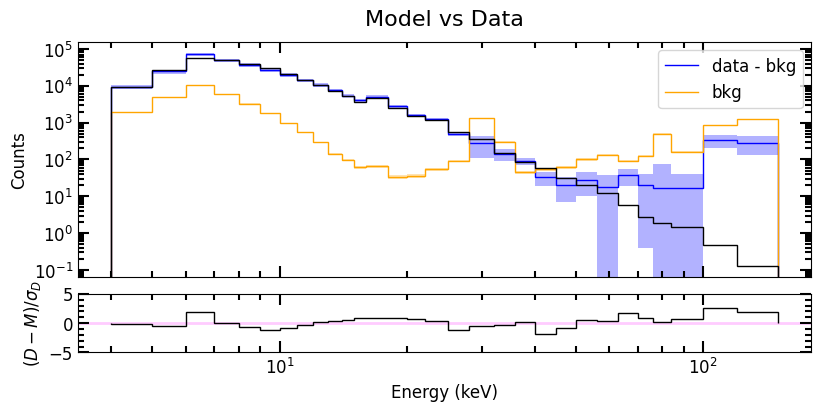

In [10]:
# Plot the current fit to see how we're doing
plotting.plot_data_model(fitter)

In [11]:
# Finally, we can run MCMC on the parameters and see how the fits worked.
fitter.run_emcee({}, {'nsteps': 1000, 'progress': True})

100%|██████████| 1000/1000 [03:01<00:00,  5.50it/s]


In [12]:
# Store the "best" parameters after this MCMC run
fitter.emplace_best_mcmc()
fitter.parameters

OrderedDict([('temperature', Parameter(1.35e+01, MK, frozen=False)),
             ('emission_measure',
              Parameter(1.06e-01, 1e+49 / cm3, frozen=False)),
             ('electron_flux',
              Parameter(1.18e+03, 1e+35 electron / s, frozen=False)),
             ('spectral_index', Parameter(6.60e+00, , frozen=False)),
             ('cutoff_energy', Parameter(6.83e+00, keV, frozen=False))])

{'fig': <Figure size 800x1000 with 5 Axes>,
 'axes': [<Axes: title={'center': 'temperature'}, ylabel='MK'>,
  <Axes: title={'center': 'emission_measure'}, ylabel='1e+49 / cm3'>,
  <Axes: title={'center': 'electron_flux'}, ylabel='1e+35 electron / s'>,
  <Axes: title={'center': 'spectral_index'}>,
  <Axes: title={'center': 'cutoff_energy'}, ylabel='keV'>]}

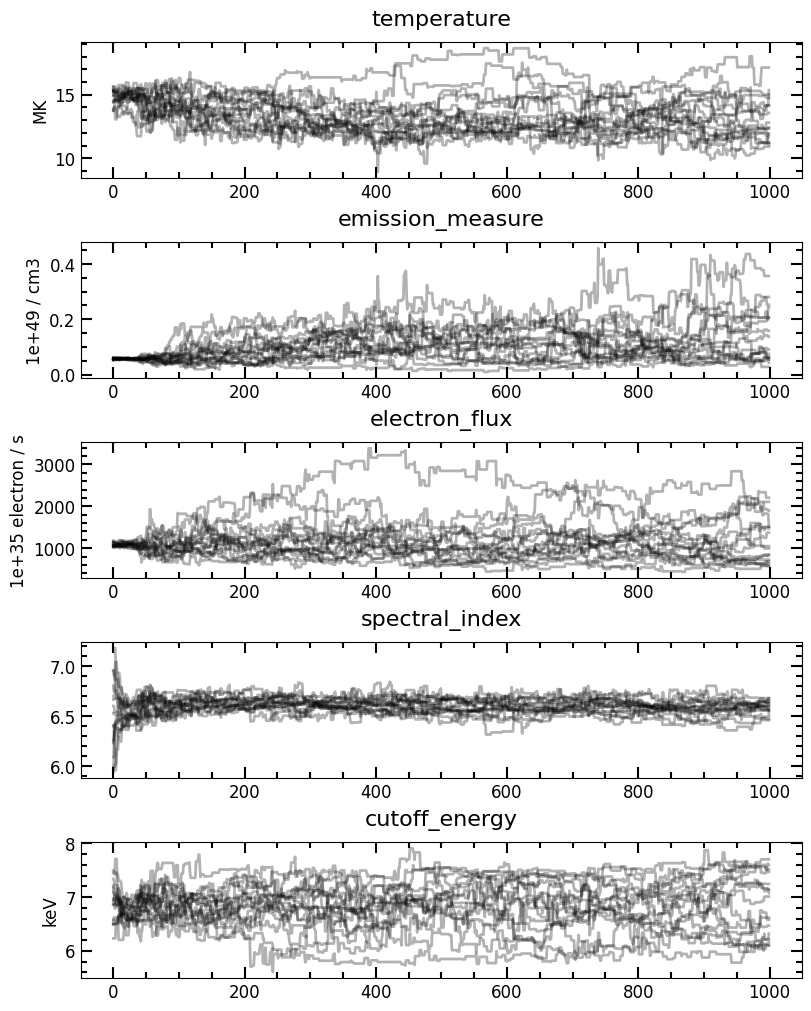

In [13]:
fig = plt.figure(figsize=(8, 10))
plotting.plot_parameter_chains(fitter, names=fitter.free_param_names, params=list(fitter.free_parameters.values()), fig=fig)

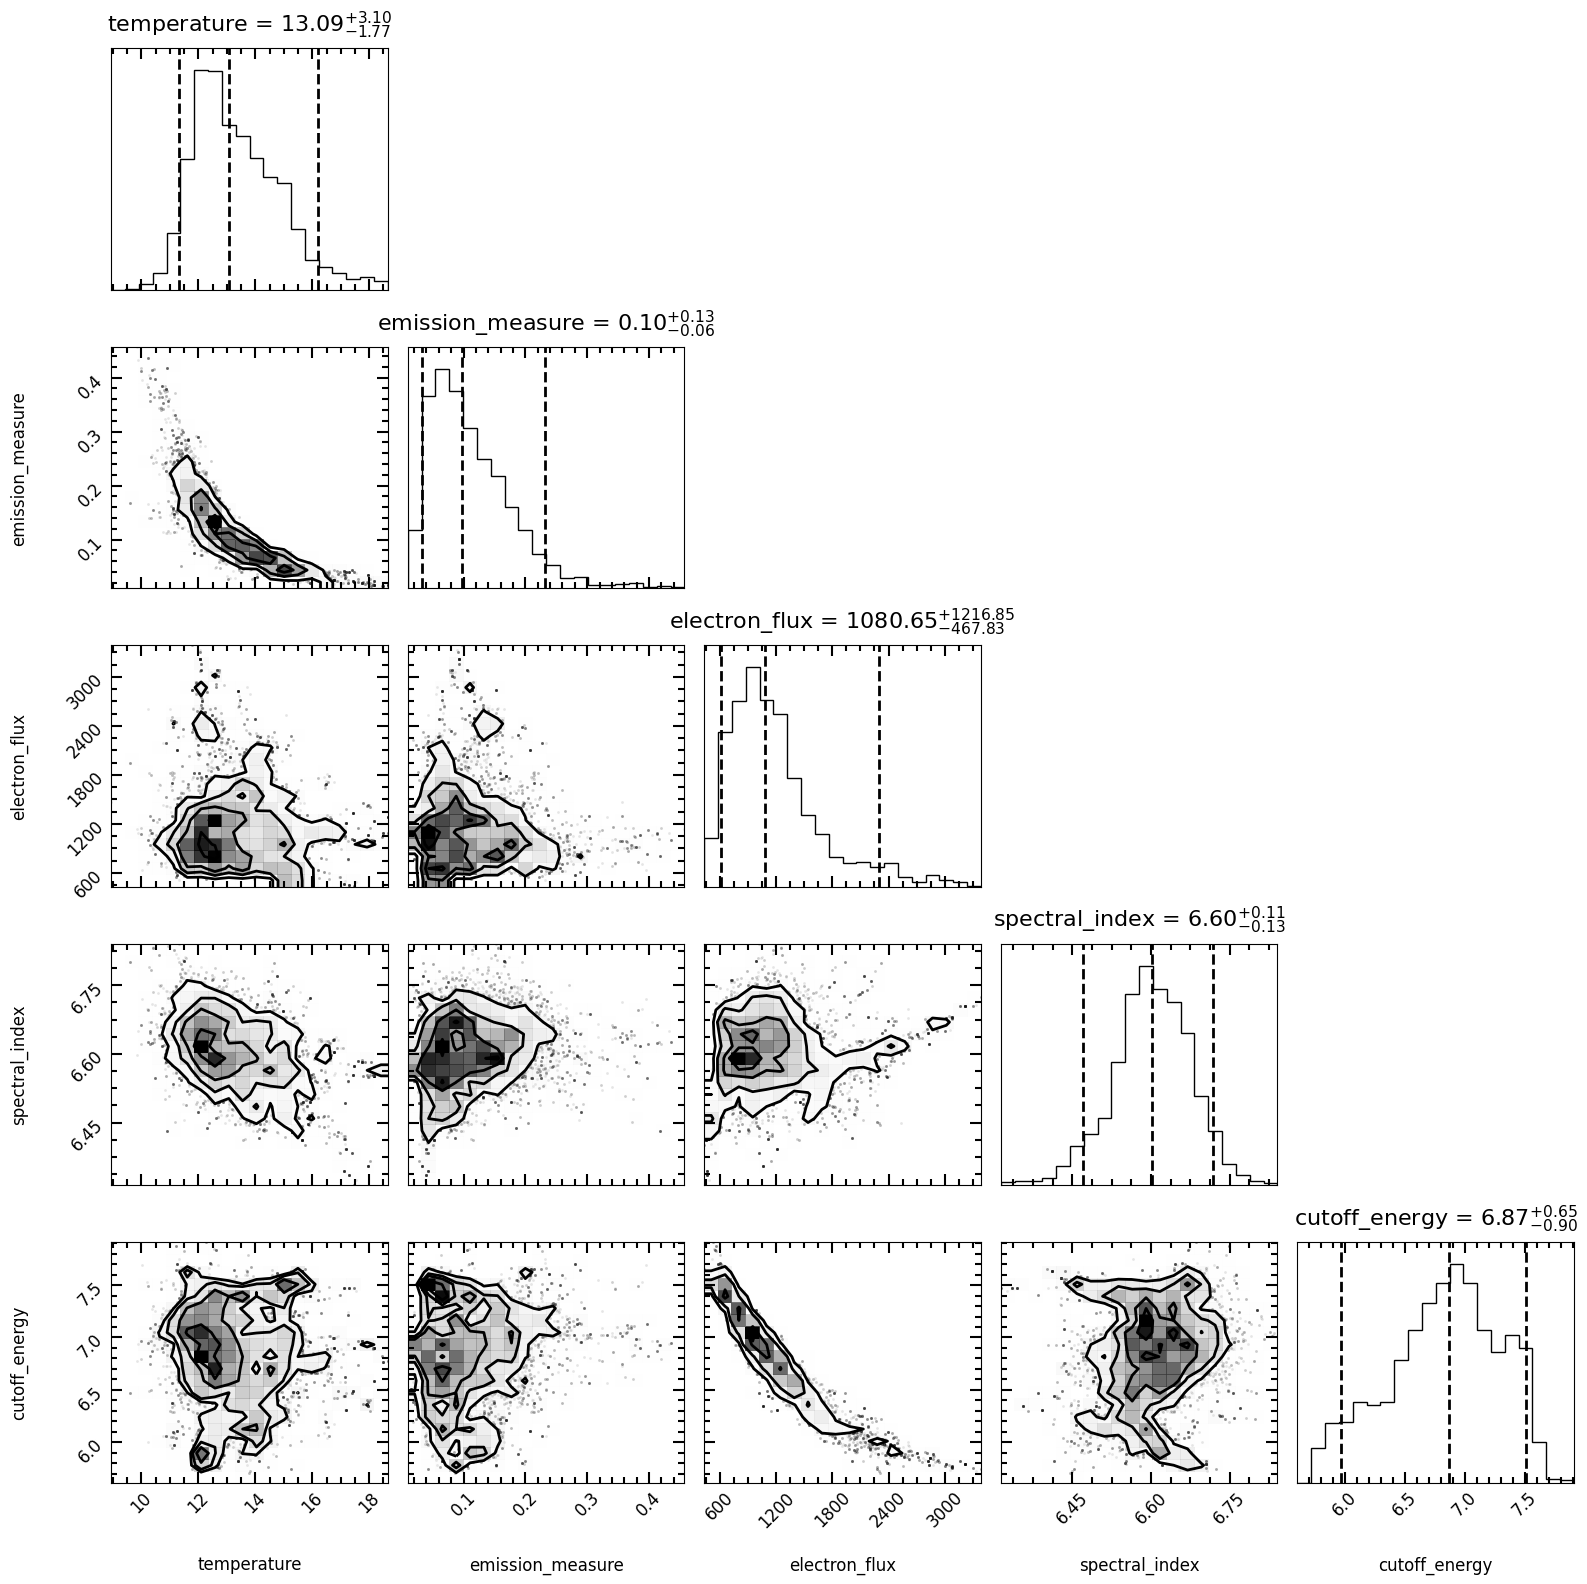

In [16]:
burnin = 100 * fitter.emcee_sampler.chain.shape[0]
fig = plt.figure(figsize=(16, 16), layout='tight')
_ = plotting.corner_plot(fitter, burnin=burnin, fig=fig)

## Finally, plot the fit and see how we did

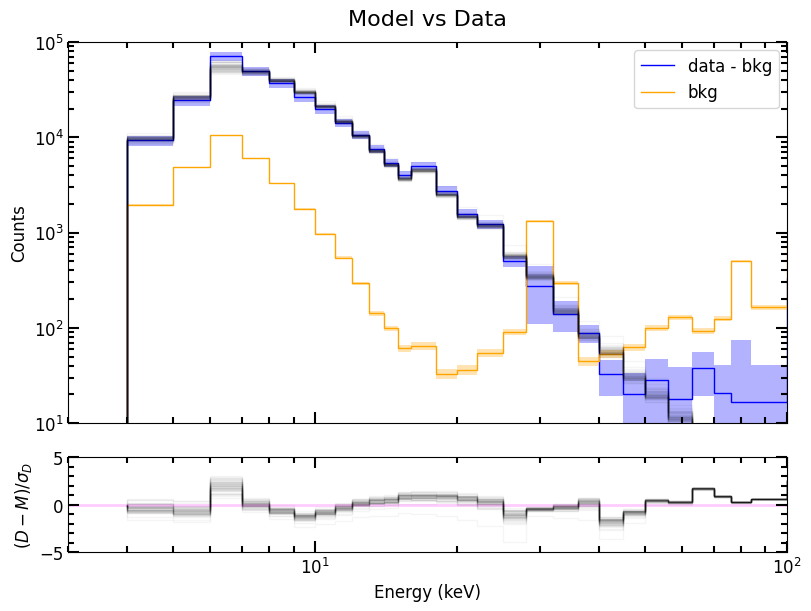

In [15]:
import importlib
importlib.reload(plotting)

fig = plt.figure(figsize=(8, 6))
samples = fitter.generate_model_samples(num=50)
plot_ret = plotting.plot_data_model(fitter, samples, fig=fig)

plot_ret['data_ax'].set(ylim=(1e1, 1e5), xlim=(3, 100))
plot_ret['error_ax'].set(ylim=(-5, 5))

plt.show()